<a href="https://colab.research.google.com/github/kumar045/Assignment/blob/main/IP_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Virtual Try-On using IP-Adapters Inpainting

by [Tony Assi](https://www.tonyassi.com/)

Check out the [blog post](https://huggingface.co/blog/tonyassi/virtual-try-on-ip-adapter) for this notebook

---

*This notebook requires a GPU. Go to Runtime->Change Runtime Type and select a GPU:*

A100 ✅

V100 ✅

T4 ✅

CPU ❌

TPU ❌

---

![image/jpeg](https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/r5JBiW4d1h_jK3Sy3NOOj.jpeg)

**Install libraries**

In [ ]:
!pip install diffusers accelerate

**Import libraries**

In [ ]:
from diffusers import AutoPipelineForInpainting, AutoencoderKL
from diffusers.utils import load_image
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

**Load the pipeline**

In [ ]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1", vae=vae, torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to("cuda")
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin", low_cpu_mem_usage=True)

**Load the main image**

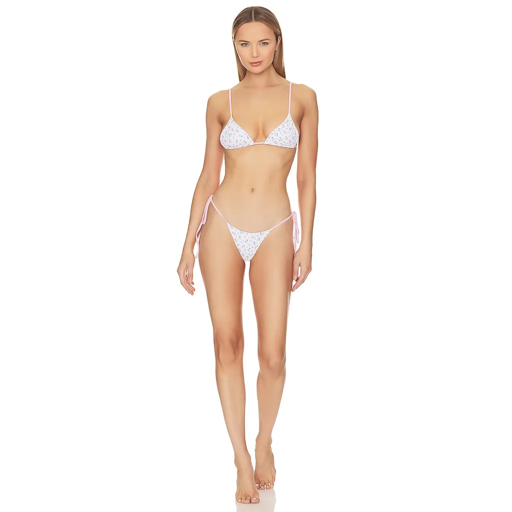

In [ ]:
image = load_image('https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/jpFBKqYB3BtAW26jCGJKL.jpeg').convert("RGB")
image.resize((512, 512))

**Load the clothing image**

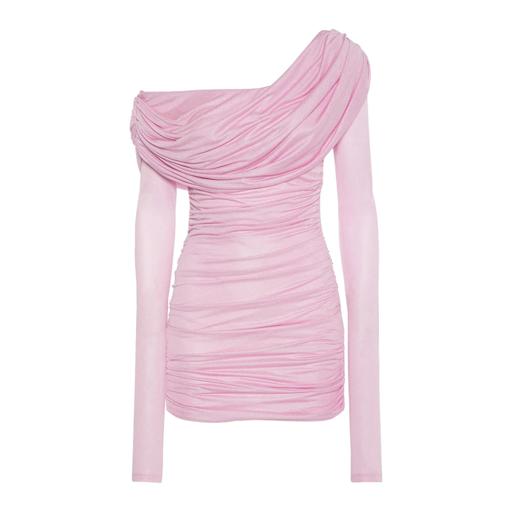

In [ ]:
ip_image = load_image('https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/NL6mAYJTuylw373ae3g-Z.jpeg').convert("RGB")
ip_image.resize((512, 512))

**Create the mask image**

To create the mask image we're going to use a [body segmentation tool](https://github.com/TonyAssi/Segment-Body) that will do it automatically

In [ ]:
! git clone https://github.com/TonyAssi/Segment-Body.git
%cd /content/Segment-Body
! pip install -r requirements.txt
! cp ./SegBody.py ..
%cd ..

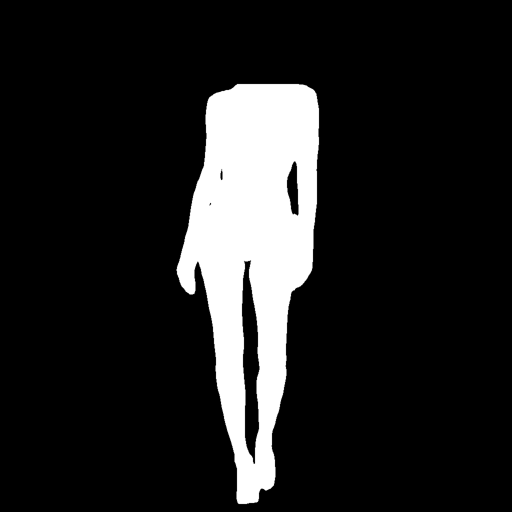

In [ ]:
from SegBody import segment_body
seg_image, mask_image = segment_body(image, face=False)
mask_image.resize((512, 512))

**Generate image**

  0%|          | 0/99 [00:00<?, ?it/s]

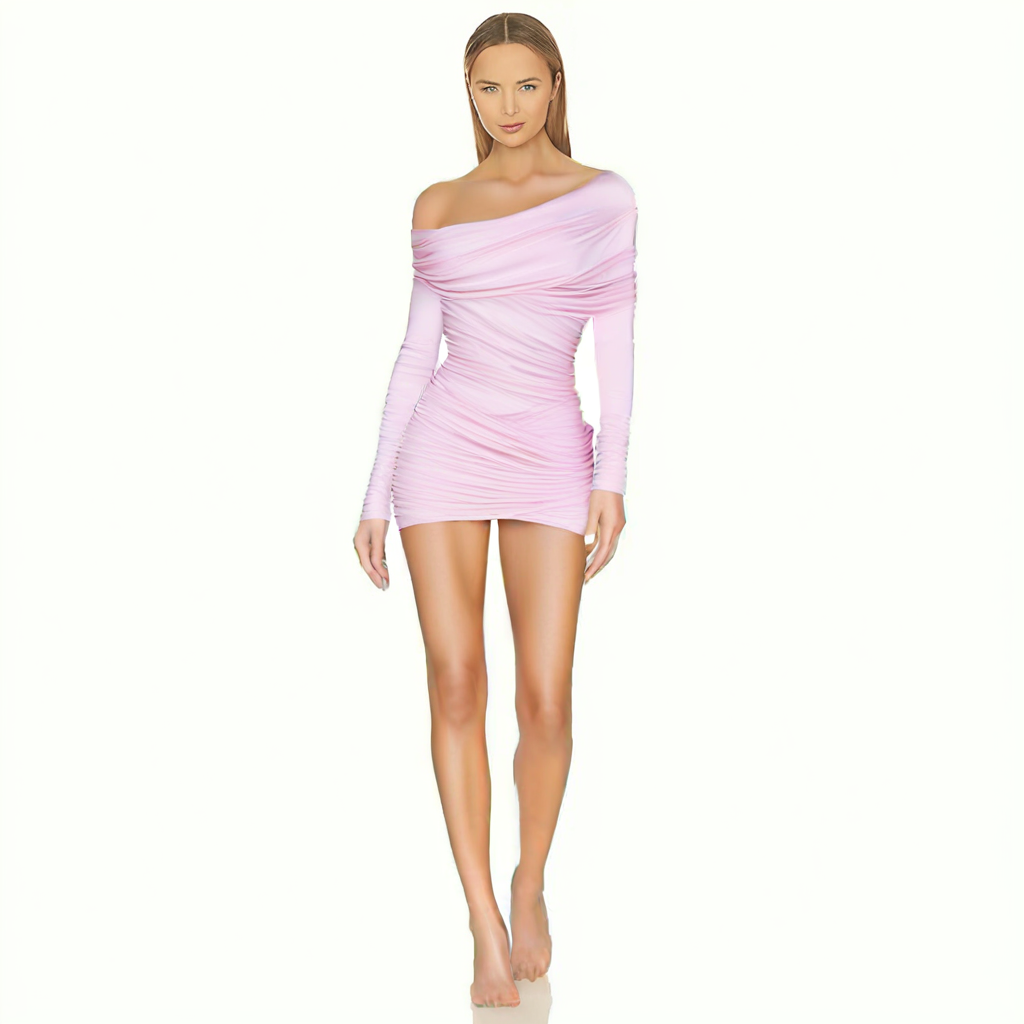

In [ ]:
pipeline.set_ip_adapter_scale(1.0)
images = pipeline(
    prompt="photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
    negative_prompt="ugly, bad quality, bad anatomy, deformed body, deformed hands, deformed feet, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings",
    image=image,
    mask_image=mask_image,
    ip_adapter_image=ip_image,
    strength=0.99,
    guidance_scale=7.5,
    num_inference_steps=100,
).images
images[0]

**Virtual Try-On Function**

Now lets put it all together into a function so that all you need to do is pass the image and the clothing

In [ ]:
def virtual_try_on(img, clothing, prompt, negative_prompt, ip_scale=1.0, strength=0.99, guidance_scale=7.5, steps=100):
    _, mask_img = segment_body(img, face=False)
    pipeline.set_ip_adapter_scale(ip_scale)
    images = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=img,
        mask_image=mask_img,
        ip_adapter_image=clothing,
        strength=strength,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
    ).images
    return images[0]

In [ ]:
image = load_image('https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/jpFBKqYB3BtAW26jCGJKL.jpeg').convert("RGB")
ip_image = load_image('https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/NL6mAYJTuylw373ae3g-Z.jpeg').convert("RGB")

  0%|          | 0/99 [00:00<?, ?it/s]

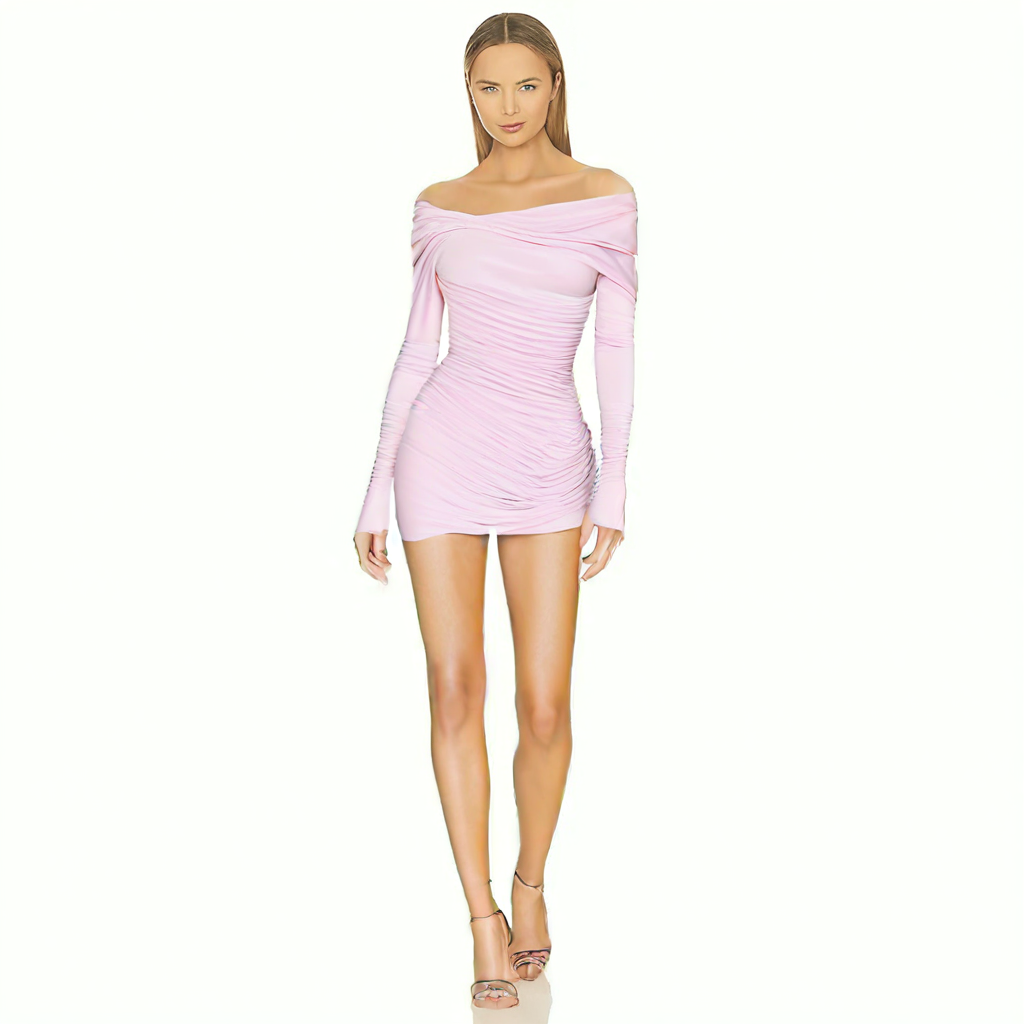

In [ ]:
virtual_try_on(img=image,
               clothing=ip_image,
               prompt="photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
               negative_prompt="ugly, bad quality, bad anatomy, deformed body, deformed hands, deformed feet, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings")